# C964 Computer Science Capstone
## An Analysis of Climate Variables on Corn Yields

### Import Libraries

In [26]:
import pandas as pandas
import numpy as numpy
import seaborn as seaborn
import matplotlib.pyplot as pyplot
import matplotlib.image as display
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import warnings

# SUPPRESS USER WARNING RELATED TO POLYNOMIAL FEATURE NAMING
# CAUSE: No year provided with test data
warnings.filterwarnings("ignore", category=UserWarning)

### Load and Preprocess Data

In [5]:
# LOAD DATA
crop_data = pandas.read_csv('corn_bushels_per_acre_by_state.csv')
temp_data = pandas.read_csv('average_monthly_temperature_by_state.csv')
drought_data = pandas.read_csv('monthly_drought_monitor_by_state.csv')

# NORMALIZE FORMATTING AND REMOVE LESS RELEVANT DATA
# Change drought data format from string to year and month
drought_data['date'] = drought_data['date'].str[2:] # Remove 'd_' prefix
drought_data['year'] = drought_data['date'].str[:4].astype(int)
drought_data['month'] = drought_data['date'].str[4:6].astype(int)
# Capitalize state names and normalize space usage
crop_data['state'] = crop_data['state'].str.replace('-', ' ').str.upper().str.strip()
temp_data['state'] = temp_data['state'].str.replace('-', ' ').str.upper().str.strip()
drought_data['state'] = drought_data['state'].str.replace('-', ' ').str.upper().str.strip()

# MERGE TEMPERATURE AND DROUGHT DATA
monthly_climate = pandas.merge(
    temp_data[['state', 'year', 'month', 'average_temp']],
    drought_data[['state', 'year', 'month', 'N0',
                  'D0', 'D1', 'D2', 'D3', 'D4',
                  'W0', 'W1', 'W2', 'W3', 'W4']],
    on = ['state', 'year', 'month'],
    how = 'inner'
)
# Trim data to relevant time frame
monthly_climate = monthly_climate[(monthly_climate['year'] >= 1970) & (monthly_climate['year'] <= 2020)]
monthly_climate = monthly_climate[(monthly_climate['month'] >= 4) & (monthly_climate['month'] <= 11)]
# Save the merged dataset
monthly_climate.to_csv('monthly_climate_by_state.csv')

# PIVOT MONTHLY CLIMATE DATA FOR EACH CLIMATE FEATURE
climate_pivot = monthly_climate.pivot_table(
    index=['state', 'year'],
    columns='month',
    values=['average_temp', 'N0', 'D0', 'D1', 'D2', 'D3', 'D4', 'W0', 'W1', 'W2', 'W3', 'W4']
)
# Flatten the multi-level columns (concatenate feature and month)
climate_pivot.columns = [f"{col[0]}_{col[1]}" for col in climate_pivot.columns]
climate_pivot = climate_pivot.reset_index()
# Save the pivoted dataset
climate_pivot.to_csv('climate_pivot.csv')

# MERGE PIVOTED DATASET WITH CROP DATA
model_data = pandas.merge(
    climate_pivot,
    crop_data[['state', 'year', 'yield']],
    on=['state','year'],
    how='inner'
)
# Encode the state and year data as categorical columns
model_data = pandas.get_dummies(model_data, columns=['state'], prefix='state')
model_data = pandas.get_dummies(model_data, columns=['year'], prefix='year')
# Save the finalized dataset
model_data.to_csv('model_data.csv')

# SPLIT DATA INTO FEATURES AND TARGETS
x = model_data.drop(columns=['yield'])
y = model_data['yield']

# SPLIT DATA INTO TRAIN AND TEST SETS
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

# STANDARDIZE SCALE OF DRY/WET AND AVERAGE TEMPERATURE DATA
scaler = StandardScaler()
# Fit and transform the training set
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
# Transform resulting array back to a dataframe with column names
x_train_scaled = pandas.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pandas.DataFrame(x_test_scaled, columns=x_test.columns)
# Save the scaler
joblib.dump(scaler,'scaler.pkl')

# APPLY POLYNOMIAL FEATURES FOR FEATURE INTERACTION
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
# Fit and transform the training set
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)
# Transform resulting array back to a dataframe with column names
poly_feature_names = poly.get_feature_names_out(x_train.columns)
x_train_poly = pandas.DataFrame(x_train_poly, columns=poly_feature_names)
x_test_poly = pandas.DataFrame(x_test_poly, columns=poly_feature_names)
# Save the polynomial feature transformer
joblib.dump(poly, 'poly.pkl')

# Print message upon completion
print(f"Data loading and preprocessing complete.")

Data loading and preprocessing complete.


### Exploratory Data Analysis

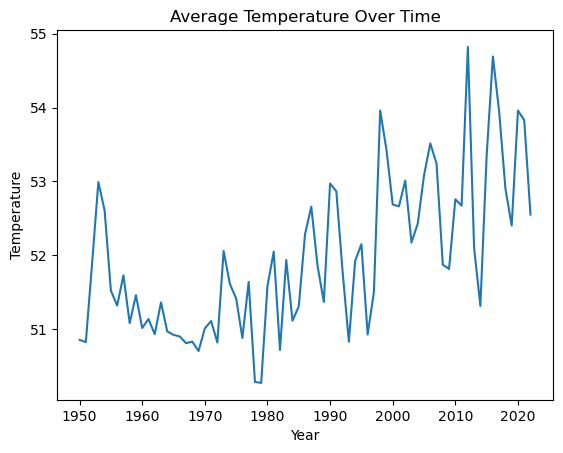

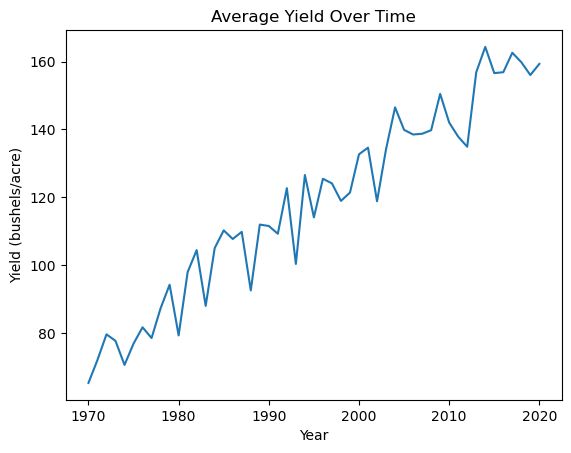

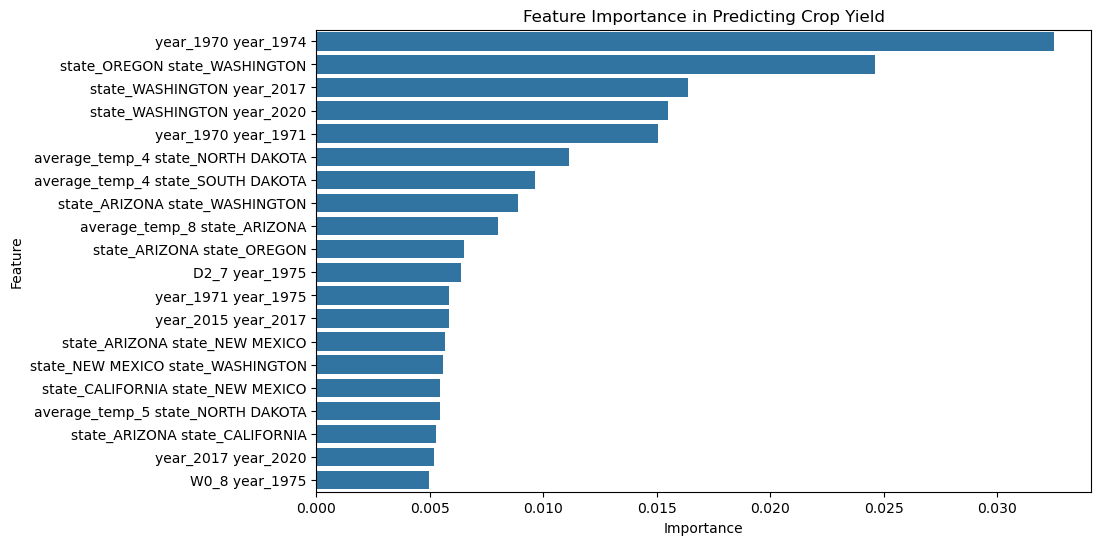

In [46]:
# TEMPERATURE TREND BY YEAR
average_temp_by_year = temp_data.groupby('year')['average_temp'].mean()
pyplot.plot(average_temp_by_year)
pyplot.title("Average Temperature Over Time")
pyplot.xlabel("Year")
pyplot.ylabel("Temperature")
pyplot.savefig('temp_trend.png')
pyplot.show()

# YIELD TREND BY YEAR
average_yield_by_year = crop_data.groupby('year')['yield'].mean()
pyplot.plot(average_yield_by_year)
pyplot.title("Average Yield Over Time")
pyplot.xlabel("Year")
pyplot.ylabel("Yield (bushels/acre)")
pyplot.savefig('yield_trend.png')
pyplot.show()

# FEATURE IMPORTANCE VISUALIZATION
importance_dataframe = pandas.read_csv('feature_importance.csv')
importance_dataframe = importance_dataframe[['Feature', 'Importance']]
importance_dataframe = importance_dataframe.sort_values(by='Importance', ascending=False)
top_20_features = importance_dataframe.head(20)
pyplot.figure(figsize=(10, 6))
seaborn.barplot(x='Importance', y='Feature', data=top_20_features)
pyplot.title("Feature Importance in Predicting Crop Yield")
pyplot.xlabel("Importance")
pyplot.ylabel("Feature")
pyplot.savefig("feature_plot.png")
pyplot.show()

### Model Training and Validation

Mean Absolute Error: 18.318581252896195
R-Squared: 0.6444141987026155


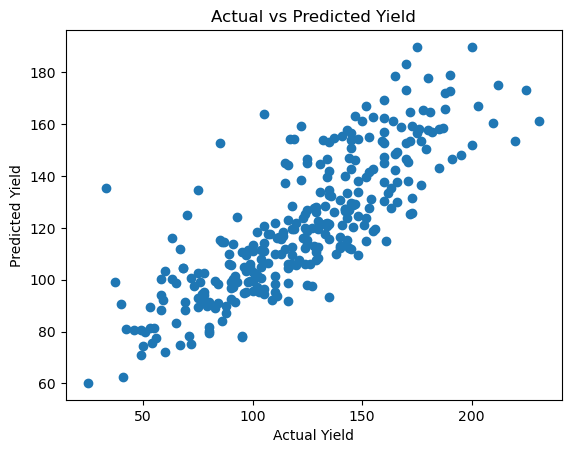

Model training is complete.


In [9]:
## HYPERPARAMETER TUNING USING CROSS-VALIDATION
## Commented out after retrieving necessary parameters
#param_grid = {
#    'n_estimators': [50, 100, 200], # Number of trees
#    'max_depth': [10, 20, None],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
#}
## Initialize Random Forest model
#rf_model = RandomForestRegressor(random_state=42)
## Initialize GridSearchCV with cross-validation
#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
#                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
## Perform grid search on training data
#grid_search.fit(x_train_scaled, y_train)
## Print best parameters
#print("Best hyperparameters found: ", grid_search.best_params_)

# INITIALIZE RANDOM FOREST MODEL WITH BEST PARAMETERS
rf_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=20,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# TRAIN RANDOM FOREST MODEL
rf_model.fit(x_train_poly, y_train)
y_pred = rf_model.predict(x_test_poly)

# EVALUATE MODEL WITH STANDARD METRICS
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"R-Squared: {r2}")

# ACTUAL VS PREDICTED YIELD VISUALIZATION
pyplot.scatter(y_test, y_pred)
pyplot.xlabel('Actual Yield')
pyplot.ylabel('Predicted Yield')
pyplot.title('Actual vs Predicted Yield')
pyplot.savefig('actual_vs_predicted.png')
pyplot.show()

# CONDUCT FEATURE IMPORTANCE ANALYSIS
importances = rf_model.feature_importances_
sorted_indices = importances.argsort()[::-1]
# Save the feature importance to a file
polynomial_feature_importance = pandas.DataFrame({
    'Feature': [poly_feature_names[i] for i in sorted_indices],
    'Importance': [importances[i] for i in sorted_indices]
})
polynomial_feature_importance.to_csv('feature_importance.csv')

# SAVE THE TRAINED MODEL
joblib.dump(rf_model, 'random_forest_model.pkl')

# Print message upon completion
print(f"Model training is complete.")

### Visualization

![](temp_trend.png)

![](yield_trend.png)

![](actual_vs_predicted.png)

### Yield Predictor

In [13]:
# LOAD THE MODEL AND SCALER
rf_model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')
poly = joblib.load('poly.pkl')

# DEFINE PREDICTION FUNCTION
def predict_yield(input_csv):
    # Load the data for predictions
    test_data = pandas.read_csv(input_csv)

    # Ensure all required columns are present in the test data
    required_columns = scaler.feature_names_in_
    test_data = test_data.reindex(columns=required_columns, fill_value=0)

    # Apply the same scaling used during training
    test_data_scaled = scaler.transform(test_data)

    # Apply polynomial feature transformation
    test_data_poly = poly.transform(test_data_scaled)

    # Convert back to dataframe with correct feature names
    test_data_poly_dataframe = pandas.DataFrame(test_data_poly, columns=poly.get_feature_names_out(required_columns))

    # Make predictions for each row in the test data
    predicted_yields = rf_model.predict(test_data_poly_dataframe)

    # Find the categorical state column for each row
    state_columns = [col for col in test_data.columns if col.startswith('state_')]

    # Print the predicted yields
    for i, yield_val in enumerate (predicted_yields):
        state_name = test_data.loc[i, state_columns].idxmax().replace('state_', '')
        print(f"Row {i+1}: The predicted yield in {state_name} is {yield_val:.2f} bushels per acre.")

predict_yield('prediction_test_data.csv')

Row 1: The predicted yield in TEXAS is 99.86 bushels per acre.
Row 2: The predicted yield in IOWA is 105.15 bushels per acre.
Row 3: The predicted yield in MISSOURI is 118.28 bushels per acre.
